# Imports

In [135]:
%matplotlib inline

import numpy as np
import pandas as pd

from astropy.coordinates import SkyCoord, FK5
from astropy.io import fits
from astropy import units as u

import matplotlib.pyplot as plt

# Load data

Looking at one system, already with downloaded ugriz .fits files, first...

In [220]:
# Elliptical galaxy
uband = fits.open('J0943p0024/frame-u-000756-4-0200.fits')
gband = fits.open('J0943p0024/frame-g-000756-4-0200.fits')
rband = fits.open('J0943p0024/frame-r-000756-4-0200.fits')
iband = fits.open('J0943p0024/frame-i-000756-4-0200.fits')
zband = fits.open('J0943p0024/frame-z-000756-4-0200.fits')
coords = SkyCoord(145.8002, 0.4141723, unit=(u.deg, u.deg))

# Little Cub
#uband = fits.open('LittleCub/frame-u-002078-4-0032.fits')
#gband = fits.open('LittleCub/frame-g-002078-4-0032.fits')
#rband = fits.open('LittleCub/frame-r-002078-4-0032.fits')
#iband = fits.open('LittleCub/frame-i-002078-4-0032.fits')
#zband = fits.open('LittleCub/frame-z-002078-4-0032.fits')
#coords = SkyCoord("10:44:42.66 +63:06:02.08", unit=(u.hourangle, u.deg))

# Leo P
#uband = fits.open('LeoP/frame-u-005935-5-0260.fits')
#gband = fits.open('LeoP/frame-g-005935-5-0260.fits')
#rband = fits.open('LeoP/frame-r-005935-5-0260.fits')
#iband = fits.open('LeoP/frame-i-005935-5-0260.fits')
#zband = fits.open('LeoP/frame-z-005935-5-0260.fits')
#coords = SkyCoord("10:21:45.12 +18:05:16.88", unit=(u.hourangle, u.deg))

print (coords)

<SkyCoord (ICRS): (ra, dec) in deg
    (145.8002, 0.4141723)>


In [221]:
gband[0].header

SIMPLE  =                    T /                                                
BITPIX  =                  -32 / 32 bit floating point                          
NAXIS   =                    2                                                  
NAXIS1  =                 2048                                                  
NAXIS2  =                 1489                                                  
EXTEND  =                    T /Extensions may be present                       
BZERO   =              0.00000 /Set by MRD_SCALE                                
BSCALE  =              1.00000 /Set by MRD_SCALE                                
TAI     =        4428795142.48 / 1st row - Number of seconds since Nov 17 1858  
RA      =            146.37926 / 1st row - Right ascension of telescope boresigh
DEC     =           -0.002768  / 1st row - Declination of telescope boresight (d
SPA     =              90.005  / 1st row - Camera col position angle wrt north (
IPA     =              89.95

# Convert object's RA, DEC to (x,y) pixel location on image

In [178]:
def object_RADEC_to_XY(obj_RA, obj_DEC, fits_header):
    '''
    Function copied from: 
    https://acrider.wordpress.com/2015/02/04/revised-python-code-for-converting-ra-dec-to-x-y/
    
    and is closely adapted from IDL's AD2XY.PRO:
    http://www.sdss3.org/svn/repo/idlutils/tags/v5_5_5/goddard/pro/astrom/ad2xy.pro
    
    Also check out:
    https://www.galaxyzooforum.org/index.php?topic=280337.0
    https://forum.cosmoquest.org/showthread.php?137475-How-to-cut-out-a-region-from-an-SDSS-FITS-image-file
    
    Parameters
    ----------
    obj_RA : float
        object right ascension in degrees
    obj_DEC : float
        object declination in degrees
    fits_header : HDUList
        FITS file header info
        
    Returns
    -------
    obj_X : float
        object x-coordinate
    obj_Y : float
        object y-coordinate
    '''
    
    # Make sure the RA, DEC coordinate type is TAN
    if (fits_header['CTYPE1'] != 'RA---TAN') or (fits_header['CTYPE2'] != 'DEC--TAN'):
        print ('ERROR: Wrong coordinate type CTYPE1 or CTYPE2 for this object!')
        print ('\t CTYPE1 = ', fits_header['CTYPE1'])
        print ('\t CTYPE2 = ', fits_header['CTYPE2'])
        
    # These values allow translation from RA, DEC to X,Y and vice versa
    CRPIX1 = fits_header['CRPIX1'] - 1 # X of reference pixel
    CRPIX2 = fits_header['CRPIX2'] - 1 # Y of reference pixel
    CRVAL1 = fits_header['CRVAL1'] # RA of reference pixel (deg)
    CRVAL2 = fits_header['CRVAL2'] # DEC of reference pixel (deg)
    CD1_1 = fits_header['CD1_1'] # RA deg per column pixel
    CD1_2 = fits_header['CD1_2'] # RA deg per row pixel
    CD2_1 = fits_header['CD2_1'] # DEC deg per column pixel
    CD2_2 = fits_header['CD2_2'] # DEC deg per row pixel
    
    # Find the X, Y values of the galaxy's RA and DEC
    det = CD1_1 * CD2_2 - CD1_2 * CD2_1

    CD_inv_11 = CD2_2 / det
    CD_inv_12 = -CD1_2 / det
    CD_inv_21 = -CD2_1 / det
    CD_inv_22 = CD1_1 / det

    ra0 = CRVAL1 / 180.0 * np.pi
    dec0 = CRVAL2 / 180.0 * np.pi
    ra = obj_RA / 180.0 * np.pi
    dec = obj_DEC / 180.0 * np.pi

    denominator = np.sin(dec)*np.sin(dec0) + np.cos(dec)*np.cos(dec0)*np.cos(ra-ra0)

    xi = np.cos(dec) * np.sin(ra-ra0) / denominator
    eta = (np.sin(dec)*np.cos(dec0) - np.cos(dec)*np.sin(dec0)*np.cos(ra-ra0)) / denominator
    xi = xi * 180.0 / np.pi
    eta = eta * 180.0 / np.pi

    obj_X = CD_inv_11 * xi + CD_inv_12 * eta + CRPIX1
    obj_Y = CD_inv_21 * xi + CD_inv_22 * eta + CRPIX2

    return obj_X, obj_Y

## Calculate (x,y) pixel coordinates for ugriz bands

In [222]:
ux, uy = object_RADEC_to_XY(coords.ra.value, coords.dec.value, uband[0].header)
print (ux, uy)

gx, gy = object_RADEC_to_XY(coords.ra.value, coords.dec.value, gband[0].header)
print (gx, gy)

rx, ry = object_RADEC_to_XY(coords.ra.value, coords.dec.value, rband[0].header)
print (rx, ry)

ix, iy = object_RADEC_to_XY(coords.ra.value, coords.dec.value, iband[0].header)
print (ix, iy)

zx, zy = object_RADEC_to_XY(coords.ra.value, coords.dec.value, zband[0].header)
print (zx, zy)

1924.9745803317744 949.4915849725992
1923.7172083797932 954.5158166929345
1922.8381353388913 943.7396602170237
1922.6110655118428 947.0572008331305
1921.714530004453 951.4158588720214


## Determine x and y range for 32 x 32 image

Centered around the central (x, y) pixel of object/galaxy

### Test on just g-band image

In [180]:
gband[0].shape # rows (number of y pixels), columns (number of x pixels)

(1489, 2048)

In [181]:
int(round(gx, 0)), int(round(gy, 0))

(1924, 955)

In [182]:
gx, gy

(1923.7172083797932, 954.5158166929345)

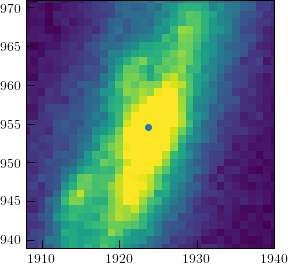

In [223]:
gxmin, gxmax = int(round(gx, 0))-16, int(round(gx, 0))+16
gymin, gymax = int(round(gy, 0))-16, int(round(gy, 0))+16

plt.imshow(gband[0].data, vmin=0.006, vmax=0.8)
plt.scatter(gx, gy)
plt.gca().invert_yaxis()
plt.xlim(gxmin, gxmax)
plt.ylim(gymin, gymax)
plt.show()

In [224]:
# x and y range defining the 32 x 32 pixel image
uxmin, uxmax = int(round(ux, 0))-16, int(round(ux, 0))+16
uymin, uymax = int(round(uy, 0))-16, int(round(uy, 0))+16

gxmin, gxmax = int(round(gx, 0))-16, int(round(gx, 0))+16
gymin, gymax = int(round(gy, 0))-16, int(round(gy, 0))+16

rxmin, rxmax = int(round(rx, 0))-16, int(round(rx, 0))+16
rymin, rymax = int(round(ry, 0))-16, int(round(ry, 0))+16

ixmin, ixmax = int(round(ix, 0))-16, int(round(ix, 0))+16
iymin, iymax = int(round(iy, 0))-16, int(round(iy, 0))+16

zxmin, zxmax = int(round(zx, 0))-16, int(round(zx, 0))+16
zymin, zymax = int(round(zy, 0))-16, int(round(zy, 0))+16

In [225]:
# Potentially useful info for vmin, vmax in imshow(), but not necessary for cropping image
print (np.min(uband[0].data.flatten()), np.max(uband[0].data.flatten()))
print (np.min(gband[0].data.flatten()), np.max(gband[0].data.flatten()))
print (np.min(rband[0].data.flatten()), np.max(rband[0].data.flatten()))
print (np.min(iband[0].data.flatten()), np.max(iband[0].data.flatten()))
print (np.min(zband[0].data.flatten()), np.max(zband[0].data.flatten()))

ulev = np.percentile(uband[0].data.flatten(), [16, 50, 84])
glev = np.percentile(gband[0].data.flatten(), [16, 50, 84])
rlev = np.percentile(rband[0].data.flatten(), [16, 50, 84])
ilev = np.percentile(iband[0].data.flatten(), [16, 50, 84])
zlev = np.percentile(zband[0].data.flatten(), [16, 50, 84])

print (ulev, glev, rlev, ilev, zlev)

-0.2084961 287.5
-0.09289551 177.0
-0.13183594 221.5
-0.24023438 115.125
-1.1269531 1920.0
[-0.0411377   0.00216293  0.04534912] [-0.01782227 -0.00014567  0.02017212] [-0.02670288  0.00140381  0.02984619] [-0.04351807  0.00093651  0.05029297] [-0.20996094  0.01205444  0.23486328]


In [186]:
# Desired N x N image size
pix_sz = 16

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


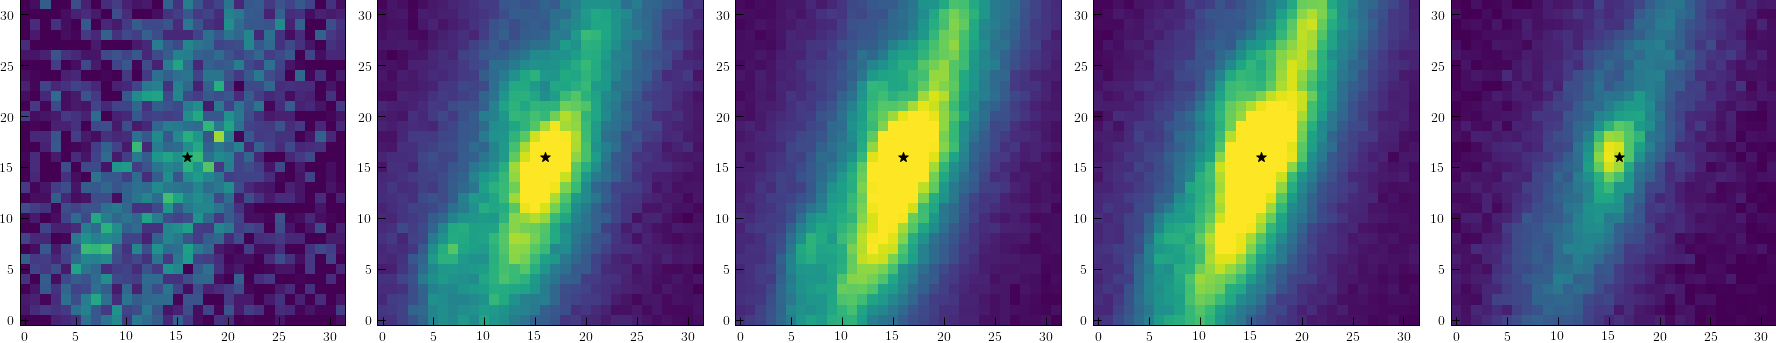

In [226]:
# Plot cropped ugriz images with central pixel of galaxy in that band
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25, 5))

ax1.imshow(uband[0].data[uymin:uymax, uxmin:uxmax], vmin=0.002, vmax=0.4)
ax1.scatter(pix_sz, pix_sz, marker='*', color='black', s=100)
ax1.invert_yaxis()

ax2.imshow(gband[0].data[gymin:gymax, gxmin:gxmax], vmin=0.0001, vmax=1.0)
ax2.scatter(pix_sz, pix_sz, marker='*', color='black', s=100)
ax2.invert_yaxis()

ax3.imshow(rband[0].data[rymin:rymax, rxmin:rxmax], vmin=0.002, vmax=2.0)
ax3.scatter(pix_sz, pix_sz, marker='*', color='black', s=100)
ax3.invert_yaxis()

ax4.imshow(iband[0].data[iymin:iymax, ixmin:ixmax], vmin=0.001, vmax=3.0)
ax4.scatter(pix_sz, pix_sz, marker='*', color='black', s=100)
ax4.invert_yaxis()

ax5.imshow(zband[0].data[zymin:zymax, zxmin:zxmax], vmin=0.002, vmax=10.)
ax5.scatter(pix_sz, pix_sz, marker='*', color='black', s=100)
ax5.invert_yaxis()

fig.savefig('J0943p0024/J0943p0024_ugriz_fits.pdf')
fig.show()

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


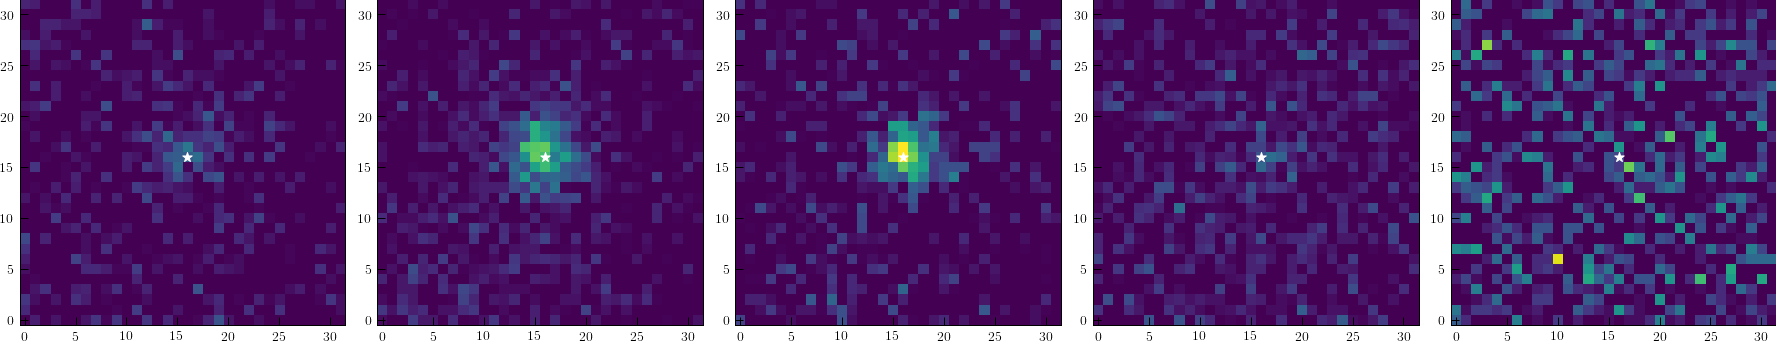

In [219]:
# Plot cropped ugriz images with central pixel of galaxy in that band
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25, 5))

ax1.imshow(uband[0].data[uymin:uymax, uxmin:uxmax], vmin=0.02, vmax=0.4)
ax1.scatter(pix_sz, pix_sz, marker='*', color='white', s=100)
ax1.invert_yaxis()

ax2.imshow(gband[0].data[gymin:gymax, gxmin:gxmax], vmin=0.01, vmax=0.2)
ax2.scatter(pix_sz, pix_sz, marker='*', color='white', s=100)
ax2.invert_yaxis()

ax3.imshow(rband[0].data[rymin:rymax, rxmin:rxmax], vmin=0.02, vmax=0.2)
ax3.scatter(pix_sz, pix_sz, marker='*', color='white', s=100)
ax3.invert_yaxis()

ax4.imshow(iband[0].data[iymin:iymax, ixmin:ixmax], vmin=0.01, vmax=0.4)
ax4.scatter(pix_sz, pix_sz, marker='*', color='white', s=100)
ax4.invert_yaxis()

ax5.imshow(zband[0].data[zymin:zymax, zxmin:zxmax], vmin=0.002, vmax=0.8)
ax5.scatter(pix_sz, pix_sz, marker='*', color='white', s=100)
ax5.invert_yaxis()

fig.savefig('LittleCub/LittleCub_ugriz_fits.pdf')
fig.show()

/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


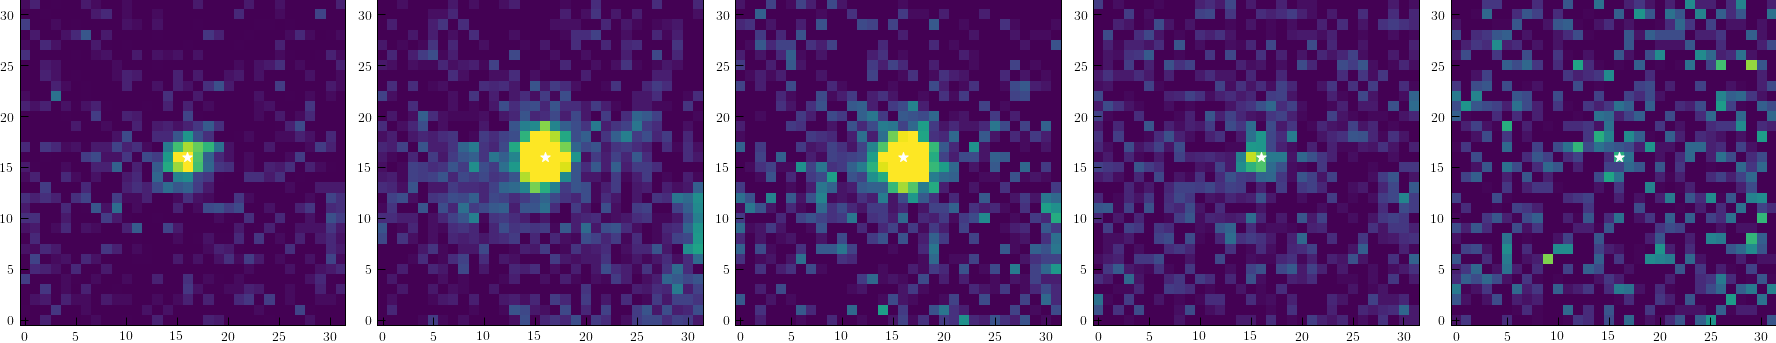

In [213]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25, 5))

ax1.imshow(uband[0].data[uymin:uymax, uxmin:uxmax], vmin=0.02, vmax=0.4)
ax1.scatter(pix_sz, pix_sz, marker='*', color='white', s=100)
ax1.invert_yaxis()

ax2.imshow(gband[0].data[gymin:gymax, gxmin:gxmax], vmin=0.01, vmax=0.2)
ax2.scatter(pix_sz, pix_sz, marker='*', color='white', s=100)
ax2.invert_yaxis()

ax3.imshow(rband[0].data[rymin:rymax, rxmin:rxmax], vmin=0.02, vmax=0.2)
ax3.scatter(pix_sz, pix_sz, marker='*', color='white', s=100)
ax3.invert_yaxis()

ax4.imshow(iband[0].data[iymin:iymax, ixmin:ixmax], vmin=0.01, vmax=0.4)
ax4.scatter(pix_sz, pix_sz, marker='*', color='white', s=100)
ax4.invert_yaxis()

ax5.imshow(zband[0].data[zymin:zymax, zxmin:zxmax], vmin=0.002, vmax=0.6)
ax5.scatter(pix_sz, pix_sz, marker='*', color='white', s=100)
ax5.invert_yaxis()

fig.savefig('LeoP/LeoP_ugriz_fits.pdf')
fig.show()

## Stack ugriz flux values in the 64 x 64 cropped image

In [198]:
stack_img = np.zeros((2*pix_sz, 2*pix_sz, 5))

In [199]:
stack_img[:, :, 0] = uband[0].data[uymin:uymax, uxmin:uxmax]
stack_img[:, :, 1] = gband[0].data[gymin:gymax, gxmin:gxmax]
stack_img[:, :, 2] = rband[0].data[rymin:rymax, rxmin:rxmax]
stack_img[:, :, 3] = iband[0].data[iymin:iymax, ixmin:ixmax]
stack_img[:, :, 4] = zband[0].data[zymin:zymax, zxmin:zxmax]

## Test stacking multiple images

In [190]:
#all_imgs = np.zeros((3, (2*pix_sz)**2*5))

In [209]:
#all_imgs[0] = stack_img.flatten()
#all_imgs[1] = stack_img.flatten()
all_imgs[2] = stack_img.flatten()

In [210]:
all_imgs

array([[-0.02682495,  0.14379883,  0.27050781, ...,  0.2421875 ,
         0.23901367,  0.71484375],
       [-0.01907349,  0.015625  ,  0.0546875 , ..., -0.00163269,
         0.00390625, -0.11218262],
       [-0.01907349,  0.015625  ,  0.0546875 , ..., -0.00163269,
         0.00390625, -0.11218262]])

## Save ugriz flux values in flattened array

In [212]:
np.savetxt('test_output_Xtrain_format.txt', all_imgs, fmt='%.12f', delimiter=" ", newline="\n")

## Test reading in the flattened array(s) and reshaping

In [115]:
tst = np.loadtxt('test.txt')

In [116]:
tst.shape

(2, 5120)

In [117]:
X_train = tst.reshape(2, 2*pix_sz, 2*pix_sz, 5)

In [118]:
X_train[0].shape, X_train[1].shape

((32, 32, 5), (32, 32, 5))

In [119]:
X_train.shape

(2, 32, 32, 5)

# galSpec query results

In [123]:
galspec = pd.read_csv('galspec_RS_uimg.csv', delimiter=',')

In [124]:
galspec

,specObjID,oii_3726_flux,oii_3726_flux_err,oii_3729_flux,oii_3729_flux_err,oiii_4363_flux,oiii_4363_flux_err,h_beta_flux,h_beta_flux_err,oiii_4959_flux,...,z_warning,targettype,spectrotype,subclass,sn_median,reliable,run,camcol,field,uimg
0,299489676975171584,307.00140,2327.571000,34.059770,159.323600,2.330947,6.684836,98.786780,6.727546,30.881300,...,0,GALAXY,GALAXY,NaN,38.082610,1,756.0,1.0,206.0,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
1,299489677444933632,0.00000,-0.764372,0.000000,-0.764372,14.544610,6.551525,119.495600,6.650275,24.923760,...,0,GALAXY,GALAXY,STARFORMING,39.110620,1,756.0,1.0,206.0,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
2,299490502078654464,39.05738,7.645567,27.096570,7.928473,0.903860,3.333012,25.640470,2.906838,9.876856,...,0,GALAXY,GALAXY,STARFORMING,18.075250,1,1239.0,2.0,175.0,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
3,299491051364706304,29.87828,6.475568,19.592310,6.553017,-1.443974,3.117991,47.366500,3.055110,0.172112,...,0,GALAXY,GALAXY,STARBURST,5.252150,1,NaN,NaN,NaN,NaN
4,299491051834468352,48.75391,5.241384,47.949990,5.445445,-6.008739,2.396007,38.332260,2.279489,12.637830,...,0,GALAXY,GALAXY,STARFORMING,8.069353,1,756.0,1.0,206.0,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252451,3348585829176993792,23.97762,3.755828,25.246790,3.795217,2.233486,2.257101,19.122970,2.194143,4.510865,...,0,GALAXY,GALAXY,NaN,20.013680,1,4679.0,1.0,254.0,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
252452,3348590776979318784,99.57286,4.212568,89.888190,4.095414,2.968016,2.169650,177.054800,3.238337,13.914340,...,0,GALAXY,GALAXY,STARBURST,20.941320,1,4679.0,1.0,251.0,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
252453,3348592976002574336,0.00000,-0.760245,0.000000,-0.760245,-1.269585,1.310876,9.911286,1.339699,5.348741,...,0,GALAXY,GALAXY,STARFORMING,9.299877,1,6161.0,5.0,124.0,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
252454,3348596274537457664,123.97060,4.732935,141.308800,4.831325,0.485705,1.924320,111.930900,2.520613,22.000050,...,0,GALAXY,GALAXY,STARBURST,16.138150,1,2207.0,5.0,169.0,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...


In [27]:
galspec[galspec['subclass'] == 'STARFORMING']

,specObjID,oii_3726_flux,oii_3726_flux_err,oii_3729_flux,oii_3729_flux_err,oiii_4363_flux,oiii_4363_flux_err,h_beta_flux,h_beta_flux_err,oiii_4959_flux,...,ra,dec,z,z_err,z_warning,spectrotype,subclass,sn_median,reliable,uimg
0,299610073498413056,32.239510,9.289029,51.520840,9.391968,6.583977,4.067094,62.27009,3.727642,25.256910,...,145.8002,0.414172,0.025250,0.000015,0,GALAXY,STARFORMING,24.851770,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
1,300619975029188608,22.840210,5.347836,12.878540,5.433570,-2.936492,2.588634,13.65540,2.449598,0.556210,...,148.5656,-0.936083,0.089717,0.000015,0,GALAXY,STARFORMING,11.260740,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
2,300620799662909440,19.622090,5.103601,37.601410,5.532969,3.359770,2.401530,62.44374,2.522492,2.818213,...,148.7270,-1.120984,0.084335,0.000009,0,GALAXY,STARFORMING,10.581210,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
3,300617501128026112,67.504120,9.459218,36.288130,8.483768,5.116489,4.063403,64.29639,4.022976,16.420420,...,148.7329,-0.761159,0.086272,0.000012,0,GALAXY,STARFORMING,25.744010,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
4,300625472587327488,8.157495,4.151037,13.458470,4.343494,-0.481147,2.648729,19.97931,2.387799,4.736043,...,149.1179,0.183989,0.065808,0.000016,0,GALAXY,STARFORMING,20.971530,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252444,3348561914799089664,14.196160,3.690346,23.336850,3.444276,1.024559,1.397171,10.14655,1.283397,1.692069,...,260.3920,31.679210,0.029703,0.000015,0,GALAXY,STARFORMING,8.039813,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
252447,3348574559182809088,17.147260,3.240531,20.825790,3.336832,1.675817,1.789195,36.43328,2.041894,5.950243,...,260.5158,31.519950,0.047164,0.000012,0,GALAXY,STARFORMING,19.941670,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
252452,3348599023316527104,18.342260,2.972998,9.916848,2.900549,-1.211788,1.922055,19.75921,1.660344,4.328686,...,260.7148,32.361810,0.054428,0.000015,0,GALAXY,STARFORMING,16.008520,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
252453,3345078112172926976,31.308570,4.027195,41.325920,4.226990,5.126327,1.736035,20.14025,1.474479,8.614512,...,257.0418,36.503830,0.036337,0.000010,0,GALAXY,STARFORMING,10.832650,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...


In [122]:
# Load this table
# Find indices where subclass = 'STARFORMING' or 'STARBURST'
# Find indices where reliable is 1, z_warning is 0, uimg is not null
# Set # of total galaxies to be length of those that qualify in ^^ criteria
# For each galaxy:
# Take uimg, replace 'frame-u' with 'frame-g', 'frame-r', 'frame-i', and 'frame-z'
# Write into a file 'wget frame-u', 'wget frame-g', etc. ... to download all .fits files
# Unzip files

#### unsure if unzip should/can be done in script. Maybe separate scripts here?
#### need to relate the uimg link with the downloaded file name, which is still by
####    frame-u-00run#-camcol#-00field#

# For each galaxy:
# Given the index, create string with run#, camcol#, field# to build name of ugriz .fits files
# Read in 5 ugriz .fits files
# Take RA, DEC and find (x, y) pixel center
# take -16 to +16 box aorund (x, y) center
# stack image and place into all_imgs